A simple model using Tensorflow for classifying the traffic sign dataset. The focus of this example is to create general understanding of how Tensorflow works, the model itself is far from optimal.

This notebook can be run on CPU.

Code based on various [Tensorflow tutorials](https://www.tensorflow.org/get_started/)

# Setup

In [1]:
import os
from pathlib import Path
import collections
import time
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = Path('./trafficsign_data/train')
assert(DATA_DIR.exists())

# Input processing

In [3]:
# Data loading method
Imageset = collections.namedtuple("Imageset", ["paths", "labels1", "labels2"])

# Creates a tuple containing the image paths with corresponding labels
def find_images():
    paths = []
    labels1 = []
    labels2 = []

    for directory in DATA_DIR.glob("./*/*/"): # List directories 2 levels down
        for file in directory.glob("*.png"):
            paths.append(str(file))
            labels1.append(directory.parent.stem)
            labels2.append(directory.stem)

    return Imageset(np.array(paths), np.array(labels1), np.array(labels2))

In [4]:
# Load data & print some examples of labels
imgs_info = find_images()
print(imgs_info.labels1.shape)
print(imgs_info.labels1[0], imgs_info.labels2[0], imgs_info.paths[0])
print(imgs_info.labels1[1000], imgs_info.labels2[1000], imgs_info.paths[1000])
print(imgs_info.labels1[2000], imgs_info.labels2[2000], imgs_info.paths[2000])

(4146,)
blue_circles D10 trafficsign_data\train\blue_circles\D10\00181_05087.png
other begin trafficsign_data\train\other\begin\00024_09665.png
rectangles_up E9a trafficsign_data\train\rectangles_up\E9a\00735_07306.png


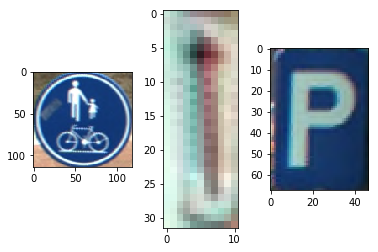

In [5]:
# Display some examples of the images
plt.figure()
plt.subplot(131)
plt.imshow(cv2.cvtColor(cv2.imread(imgs_info.paths[0]), cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.imshow(cv2.cvtColor(cv2.imread(imgs_info.paths[1000]), cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.imshow(cv2.cvtColor(cv2.imread(imgs_info.paths[2000]), cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# Gather the different labels
LABELS = np.unique(imgs_info.labels1).tolist()
print(LABELS)

['blue_circles', 'diamonds', 'forbidden', 'other', 'rectangles_down', 'rectangles_up', 'red_blue_circles', 'red_circles', 'reversed_triangles', 'squares', 'stop', 'triangles']


In [7]:
# Create training/validation sets - sampling per class
train_paths, val_paths, train_labels, val_labels = train_test_split(
    imgs_info.paths, imgs_info.labels1, train_size = 0.85, stratify = imgs_info.labels2)

In [8]:
# Count samples per class
train_label_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
val_label_counts = dict(zip(*np.unique(val_labels, return_counts=True)))

print("%20s  %5s %4s" % ("Class", "Train", "Val"))
for label in np.unique(train_labels):
    print("%20s: %5d %4d" % (label, train_label_counts[label], val_label_counts[label]))

               Class  Train  Val
        blue_circles:   574  102
            diamonds:   123   22
           forbidden:   151   27
               other:   799  142
     rectangles_down:    18    3
       rectangles_up:   246   44
    red_blue_circles:   163   29
         red_circles:   588  102
  reversed_triangles:   161   28
             squares:   174   31
                stop:    31    5
           triangles:   496   87


In [9]:
batch_size = 200

In [10]:
# Loading the actual images (and do any preprocessing)
def load_imgs(paths, labels, generate_transformations=False):
    imgs = []
    lbls = []
    for path, label in zip(paths, labels):
        orig_img = cv2.imread(path)
        label_onehot = np.zeros(len(LABELS))
        label_onehot[LABELS.index(label)] = 1
        
        imgs.append(cv2.resize(orig_img, (36, 36)))
        lbls.append(label_onehot)
        
        if (generate_transformations):
            (h, w, _) = orig_img.shape
            matrix = cv2.getRotationMatrix2D((h/2, w/2), 5, 1)
            imgs.append(cv2.resize(cv2.warpAffine(orig_img, matrix, (w, h)), (36, 36)))
            lbls.append(label_onehot)
            
            matrix = cv2.getRotationMatrix2D((h/2, w/2), -5, 1)
            imgs.append(cv2.resize(cv2.warpAffine(orig_img, matrix, (w, h)), (36, 36)))
            lbls.append(label_onehot)
    return np.array(imgs, dtype=np.float32)/255, np.array(lbls, dtype=np.float32)

train_x, train_y = load_imgs(train_paths, train_labels, generate_transformations=True)
validation_x, validation_y = load_imgs(val_paths, val_labels)

In [11]:
print("Original train images: ", train_paths.shape)
print("Enhanced train images: ", train_x.shape)
print("Enhanced train labels: ", train_y.shape)

Original train images:  (3524,)
Enhanced train images:  (10572, 36, 36, 3)
Enhanced train labels:  (10572, 12)


# Model creation

In [12]:
images = tf.placeholder(dtype=tf.float32, shape=(None,36,36,3), name='input_img')
labels = tf.placeholder(dtype=tf.float32, shape=(None,len(LABELS)), name='labels')

In [13]:
with tf.variable_scope('conv1') as scope:
    kernel1 = tf.Variable(tf.truncated_normal([5, 5, 3, 64], stddev=5e-2), name='weights')
    conv1 = tf.nn.conv2d(images, kernel1, [1, 1, 1, 1], padding='SAME')
    biases1 = tf.Variable(tf.constant(0.1, shape=[64]), name='biases')
    pre_activation1 = tf.nn.bias_add(conv1, biases1)
    conv1 = tf.nn.relu(pre_activation1, name=scope.name)
    tf.summary.histogram('conv1/activations', conv1)

In [14]:
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')

In [15]:
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

In [16]:
 with tf.variable_scope('conv2') as scope:
    kernel = tf.Variable(tf.truncated_normal([5, 5, 64, 64], stddev=5e-2), name='weights')
    conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.1, shape=[64]), name='biases')
    pre_activation = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(pre_activation, name=scope.name)
    tf.summary.histogram('conv2/activations', conv2)

In [17]:
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')

In [18]:
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                         strides=[1, 2, 2, 1], padding='SAME', name='pool2')

In [19]:
with tf.variable_scope('fc') as scope:
    fc_w = tf.Variable(tf.truncated_normal([9*9*64, 1000], stddev=5e-2), name='weights')
    fc_b = tf.Variable(tf.constant(0.1, shape=[1000]))
    
    pool2_flat = tf.reshape(pool2, [-1, 9*9*64])
    fc = tf.nn.relu(tf.matmul(pool2_flat, fc_w) + fc_b)

In [20]:
keep_prob = tf.placeholder(tf.float32)
fc_drop = tf.nn.dropout(fc, keep_prob)

In [21]:
# Readout layer
fc2_w = tf.Variable(tf.truncated_normal([1000, len(LABELS)]))
fc2_b = tf.Variable(tf.constant(0.1, shape=[len(LABELS)]))

y_conv = tf.matmul(fc_drop, fc2_w) + fc2_b

In [22]:
# Error calculation 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
# Logging

# Create a summary to monitor loss tensor
tf.summary.scalar("loss", cross_entropy)

# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", accuracy)

# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Running the model

In [24]:
# Running

num_examples = train_x.shape[0]
batch_start = 0
shuffling = np.arange(num_examples)
np.random.shuffle(shuffling)
train_x = train_x[shuffling]
train_y = train_y[shuffling]

with tf.Session() as sess:
    # create a log file to store all the data and summaries
    train_writer  = tf.summary.FileWriter('./logs/train', sess.graph)
    val_writer  = tf.summary.FileWriter('./logs/val')
    
    sess.run(tf.global_variables_initializer())
    for i in range(100): #500
        if batch_start + batch_size >= num_examples:
            np.random.shuffle(shuffling)
            train_x = train_x[shuffling]
            train_y = train_y[shuffling]
            batch_start = 0
        batch_x = train_x[batch_start:batch_start+batch_size]
        batch_y = train_y[batch_start:batch_start+batch_size]
        batch_start += batch_size

        _, summary, train_accuracy = sess.run([train_step, merged_summary_op, accuracy], feed_dict={images: batch_x, labels: batch_y, keep_prob: 0.5})
        train_writer.add_summary(summary, i)
        
        if i % 10 == 0:
            print('step %d, training accuracy %g' % (i, train_accuracy))
            
            val_accuracy, summary = sess.run([accuracy, merged_summary_op], feed_dict={
              images: validation_x, labels: validation_y, keep_prob: 1.0})
            val_writer.add_summary(summary, i)
            print('step %d, validation accuracy %g' % (i, val_accuracy))
        
        #a, b, c, train_accuracy = sess.run((tf.reduce_sum(kernel1), tf.reduce_sum(biases1), tf.reduce_sum(conv1), accuracy), feed_dict={
        #      images: batch_x, labels: batch_y, keep_prob: 1.0})
        #print(a, b, c, train_accuracy)



step 0, training accuracy 0.105
step 0, validation accuracy 0.229904
step 10, training accuracy 0.26
step 10, validation accuracy 0.466238
step 20, training accuracy 0.495
step 20, validation accuracy 0.655949
step 30, training accuracy 0.555
step 30, validation accuracy 0.800643
step 40, training accuracy 0.66
step 40, validation accuracy 0.845659
step 50, training accuracy 0.79
step 50, validation accuracy 0.87299
step 60, training accuracy 0.805
step 60, validation accuracy 0.900322
step 70, training accuracy 0.815
step 70, validation accuracy 0.914791
step 80, training accuracy 0.805
step 80, validation accuracy 0.92926
step 90, training accuracy 0.855
step 90, validation accuracy 0.940514


Now run Tensorboard for visualisations: `tensorboard --logdir=./logs`